# EQUIPO 36 | Avance 5: Modelo Final
## Proyecto: Predicción de infestaciones de gorgojo del agave
## Integrantes equipo 36:

| Nombre | Matrícula |
| ------ | --------- |
| André Martins Cordebello | A00572928 |
| Enrique Eduardo Solís Da Costa | A00572678 |
| Delbert Francisco Custodio Vargas | A01795613 |

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
from imblearn.ensemble  import BalancedRandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.neighbors import BallTree
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import optuna
import pickle
import time

d:\Python_Envs\torch311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargamos el dataset final

In [2]:
df = pd.read_excel("data_with_weather_information.xlsx")

In [3]:
df.dtypes

tramp_id                               object
sampling_date                  datetime64[ns]
lat                                   float64
lon                                   float64
municipality                           object
plantation_age                          int64
capture_count                         float64
state                                  object
square_area_imputed                   float64
month                                   int64
year                                    int64
year-month                             object
day_of_year_sin                       float64
day_of_year_cos                       float64
day_of_week_sin                       float64
day_of_week_cos                       float64
week_of_year_sin                      float64
week_of_year_cos                      float64
month_sin                             float64
month_cos                             float64
critical_season                         int64
severity_encoded                  

# Modelos individuales: `LightGBM` y `CatBoost`

### Carga de nuestro Train y Test set

In [4]:
# Copiamos el dataframe con la información
train_test_df = df.copy()
train_test_df = train_test_df.sort_values(by='sampling_date').reset_index(drop=True)

# Hacemos un encoding basico para State y Municipalidad
for col in ['state', 'municipality']:
    le = LabelEncoder()
    train_test_df[col] = le.fit_transform(train_test_df[col])

# Generamos la mascara para obtener los datos de antes del 2025 y del 2025 por separado
train_mask = train_test_df['sampling_date'].dt.year < 2025
test_mask  = train_test_df['sampling_date'].dt.year == 2025

# Excluimos la variable objetivo (severity_encoded) y algunos variables o features que ya tenemos contenidos en nuestros
# features creados. `capture_count` no podemos tomarlo en cuenta porque se relaciona directamente con la severidad.
exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date', 'municipality', 
    'state'
]

# Cargamos los features a tomar en cuenta (obviamos los features en exclude_cols)
features = [col for col in train_test_df.columns if col not in exclude_cols]

# Generamos nuestro split de entrenamiento y test por medio de las mascaras train_mask y test_mask
X_train, y_train = train_test_df.loc[train_mask, features], train_test_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = train_test_df.loc[test_mask,  features], train_test_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

### Modelo `LightGBM`

In [5]:
LightGBM_X_train = X_train.copy()
LightGBM_X_test  = X_test.copy()
LightGBM_Y_train = y_train.copy()
LightGBM_Y_test  = y_test.copy()

scaler = MinMaxScaler()
LightGBM_X_train[['distance_to_nearest_hotspot']] = scaler.fit_transform(LightGBM_X_train[['distance_to_nearest_hotspot']])
LightGBM_X_test[['distance_to_nearest_hotspot']] = scaler.transform(LightGBM_X_test[['distance_to_nearest_hotspot']])

lgbm_best_params = LGBMClassifier(
    boosting_type = "gbdt",
    objective = "multiclass",
    num_class = 4,
    class_weight = "balanced",
    is_unbalance = False,
    device_type = "gpu",
    min_gain_to_split = 0.001,  
    random_state = 42,
    verbose = -1,
    learning_rate= 0.031205207400998834,
    num_leaves= 110,
    max_depth= 11,
    feature_fraction= 0.91959030797181,
    bagging_fraction= 0.7694621015318531,
    lambda_l1= 1.8616621273598788,
    lambda_l2= 2.6453430076619573,
    min_child_samples= 70,
    n_estimators= 299
)

lgbm_best_params.fit(LightGBM_X_train, LightGBM_Y_train)

y_pred_lgbm_best = lgbm_best_params.predict(LightGBM_X_test, categorical_features=['critical_season'])


print("\n\nResultados para LightGBM individual:\n\n")
print(classification_report(LightGBM_Y_test, y_pred_lgbm_best, digits=3))

print("\n\nMatriz de confusión para LightGBM individual:\n")
print(confusion_matrix(y_test, y_pred_lgbm_best))


# Probabilidades
y_pred_proba_lgbm_best_params = lgbm_best_params.predict_proba(X_test)



Resultados para LightGBM individual:


              precision    recall  f1-score   support

           0      0.264     0.326     0.292     24445
           1      0.771     0.711     0.740     82928
           2      0.138     0.165     0.151      2544
           3      0.383     1.000     0.554       110

    accuracy                          0.613    110027
   macro avg      0.389     0.551     0.434    110027
weighted avg      0.643     0.613     0.626    110027



Matriz de confusión para LightGBM individual:

[[ 7964 16171   296    14]
 [21537 58955  2330   106]
 [  687  1379   421    57]
 [    0     0     0   110]]


### Modelo `CatBoost`

In [8]:
CatBoost_X_train = X_train.copy()
CatBoost_X_test  = X_test.copy()
CatBoost_Y_train = y_train.copy()
CatBoost_Y_test  = y_test.copy()

scaler = MinMaxScaler()
CatBoost_X_train[['distance_to_nearest_hotspot']] = scaler.fit_transform(CatBoost_X_train[['distance_to_nearest_hotspot']])
CatBoost_X_test[['distance_to_nearest_hotspot']] = scaler.transform(CatBoost_X_test[['distance_to_nearest_hotspot']])


class_counts = CatBoost_Y_train.value_counts().sort_index()
num_classes = len(class_counts)
total = len(CatBoost_Y_train)
class_weights = {i: total / (num_classes * count) for i, count in class_counts.items()}

weights = CatBoost_Y_train.map(class_weights)

cat_model_best = CatBoostClassifier(                 
    loss_function='MultiClass',    
    eval_metric='TotalF1',         
    auto_class_weights='Balanced', 
    random_seed=42,
    task_type='GPU',               
    #verbose=100,
    iterations= 900,
    learning_rate= 0.03169683936081736,
    depth= 8,
    l2_leaf_reg= 1.0126729009882989,
    bagging_temperature= 0.13742770730370382,
    border_count= 238,
    random_strength= 1.490982729702571,
    grow_policy= 'SymmetricTree',
    logging_level= 'Silent'
)

categorical_cols = ['critical_season']

cat_model_best.fit(
    CatBoost_X_train,
    CatBoost_Y_train,
    cat_features=categorical_cols if 'categorical_cols' in locals() else None,
    eval_set=(CatBoost_X_test, CatBoost_Y_test),
    use_best_model=True
)

y_pred_cd_best = cat_model_best.predict(CatBoost_X_test)
y_pred_cd_best = y_pred_cd_best.flatten()

print("Resultados para CatBoost según Optuna:\n")
print(classification_report(CatBoost_Y_test, y_pred_cd_best))


print("\nMatriz de confusión para CatBoost:")
print(confusion_matrix(CatBoost_Y_test, y_pred_cd_best))
y_pred_proba_cb_best_params = cat_model_best.predict_proba(CatBoost_X_test)

Resultados para CatBoost según Optuna:

              precision    recall  f1-score   support

           0       0.31      0.20      0.24     24445
           1       0.76      0.70      0.73     82928
           2       0.07      0.48      0.12      2544
           3       0.33      1.00      0.49       110

    accuracy                           0.58    110027
   macro avg       0.37      0.59      0.40    110027
weighted avg       0.64      0.58      0.61    110027


Matriz de confusión para CatBoost:
[[ 4965 17050  2411    19]
 [11127 57787 13869   145]
 [  161  1105  1214    64]
 [    0     0     0   110]]


# Estrategias de ensamble homogeneas

Estas estrategias son conocidas por combinar 2 o más modelos del mismo tipo para mejorar la estabilidad y resultados obtenidos en cuánto a las predicciones que un único modelo podría hacer. Estos ensambles se llaman homogéneos debido a que usan una combinación de un único modelo base, y por cada instancia del mismo modelo se utilizan distintos hiperparámetros (Breiman, 1996). Esto, en algunos casos, logra reducir la varianza que pueda tener un modelo y aumenta la generalización que el mismo pueda hacer. Muchas de estas estrategias buscan promediar los resultados obtenidos por cada modelo base del mismo tipo.

Algunas técnicas comunes de ensamble homogéneas son las siguientes:

- Baggin (Bootstrap Aggregating), donde se entrenan varios modelos con subconjuntos de datos generados por muestreos aleatorios.
- Boosting, donde los modelos se entrenan de manera secuencial para que cada nuevo modelo corrija errores que los modelos pasados pudieron tener.
- Stacking homogéneo, la cual mezcla distintas instancias del  mismo modelo con hiperparámetros distintos, para luego utilizar un `meta-modelo` sencillo que combine las salidas de éstas instancias.


Por ejemplo, varios `DecisionTrees`, `RandomForest` o `CatBoost` con distintos parámetros podrían formar parte de estrategias de ensamble homogéneas.

## `LightGBM Bagging`

In [11]:

import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score
from sklearn.utils import resample

# Cargamos nuestros train y test sets
Bagging_X_train = X_train.copy()
Bagging_Y_train = y_train.copy()
Bagging_X_test  = X_test.copy()
Bagging_Y_test  = y_test.copy()

#  Cantidad de modelos a generar para el Bagging
n_models = 15
models = []
oof_preds = []
test_preds = []


for i in range(n_models):
    
    # Generamos nuevos sets de entrenamiento y test por cada ciclo
    X_train_sub, y_train_sub = resample(Bagging_X_train, Bagging_Y_train, replace=True, random_state=42 + i)
    
    # Instanciamos LightGBM Classifier
    model = lgb.LGBMClassifier( 
                                boosting_type = "gbdt",
                                objective = "multiclass",
                                num_class = 4,
                                class_weight = "balanced",
                                is_unbalance = False,
                                device_type = "gpu",
                                min_gain_to_split = 0.001,  
                                random_state = 42,
                                verbose = -1,
                                learning_rate= 0.031205207400998834,
                                num_leaves= 110,
                                max_depth= 11,
                                feature_fraction= 0.91959030797181,
                                bagging_fraction= 0.7694621015318531,
                                lambda_l1= 1.8616621273598788,
                                lambda_l2= 2.6453430076619573,
                                min_child_samples= 70,
                                n_estimators= 299
                            )
    
    # Entrenamos sobre los sets de entrenamiento y test por ciclo
    model.fit(X_train_sub, y_train_sub)
    models.append(model)

    # Guardamos las predicciones out-of-fold
    y_pred = model.predict_proba(Bagging_X_test)
    test_preds.append(y_pred)

# Promediamos los resultados
avg_proba = np.mean(test_preds, axis=0)
y_pred_final = np.argmax(avg_proba, axis=1)

# Calculamos el F1 Score
f1_macro = f1_score(Bagging_Y_test, y_pred_final, average="macro")
print(f"F1-macro para Bagging con LightGBM: {f1_macro:.4f}")

# Imprimimos resultados
print("\n\nResultados para LightGBM después de usar Bagging:\n\n")
print(classification_report(Bagging_Y_test, y_pred_final, digits=3))

print("\n\nMatriz de confusión para LightGBM con bagging:\n")
print(confusion_matrix(Bagging_Y_test, y_pred_final))

F1-macro para Bagging con LightGBM: 0.4327


Resultados para LightGBM después de usar Bagging:


              precision    recall  f1-score   support

           0      0.254     0.275     0.264     24445
           1      0.765     0.745     0.755     82928
           2      0.163     0.159     0.161      2544
           3      0.381     1.000     0.551       110

    accuracy                          0.627    110027
   macro avg      0.391     0.545     0.433    110027
weighted avg      0.637     0.627     0.632    110027



Matriz de confusión para LightGBM con bagging:

[[ 6723 17538   169    15]
 [19165 61749  1907   107]
 [  623  1459   405    57]
 [    0     0     0   110]]


Para la estrategia de Bagging, notamos que `LightGBM` no tuvo una mejora, por lo que descartamos que esta sea una estrategia viable por medio de este modelo.

## `LightGBM Stacking`

In [12]:
X_train_stack = X_train.copy()
y_train_stack = y_train.copy()
X_test_stack  = X_test.copy()
y_test_stack  = y_test.copy()

lgbm_1 = lgb.LGBMClassifier(
    boosting_type='gbdt', 
    objective='multiclass', 
    num_class=4,            
    class_weight='balanced',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=-1,
    num_leaves=31,
    random_state=42,
    device='gpu',
    is_unbalance=False
)

lgbm_2 = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=10,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    random_state=42,
    device_type='gpu',
    is_unbalance=False,
    class_weight='balanced'
)

lgbm_3 = lgb.LGBMClassifier(
    boosting_type = "gbdt",
    objective = "multiclass",
    num_class = 4,
    class_weight = "balanced",
    is_unbalance = False,
    device_type = "gpu",
    min_gain_to_split = 0.001,  
    random_state = 42,
    verbose = -1,
    learning_rate= 0.031205207400998834,
    num_leaves= 110,
    max_depth= 11,
    feature_fraction= 0.91959030797181,
    bagging_fraction= 0.7694621015318531,
    lambda_l1= 1.8616621273598788,
    lambda_l2= 2.6453430076619573,
    min_child_samples= 70,
    n_estimators= 299
)

meta_model = LogisticRegression(max_iter=1000, multi_class='multinomial')


stack_model = StackingClassifier(
    estimators=[
        ('lgbm1', lgbm_1),
        ('lgbm2', lgbm_2),
        ('lgbm3', lgbm_3)
    ],
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

stack_model.fit(X_train_stack, y_train_stack)

y_pred = stack_model.predict(X_test_stack)

print("Resultados luego de hacer LightGBM Stacking")
print(classification_report(y_test_stack, y_pred, digits=4))

print("\nMatriz de confusion para LightGBM stacking:\n")
print(confusion_matrix(y_test_stack, y_pred))

d:\Python_Envs\torch311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Resultados luego de hacer LightGBM Stacking
              precision    recall  f1-score   support

           0     0.2688    0.2665    0.2676     24445
           1     0.7684    0.7923    0.7802     82928
           2     0.1034    0.0012    0.0023      2544
           3     0.3960    0.9000    0.5500       110

    accuracy                         0.6573    110027
   macro avg     0.3842    0.4900    0.4000    110027
weighted avg     0.6417    0.6573    0.6481    110027


Matriz de confusion para LightGBM stacking:

[[ 6514 17917     6     8]
 [17118 65707    12    91]
 [  605  1884     3    52]
 [    0     3     8    99]]


Por medio del uso de Stacking, vemos un ligero mejoramiento en la `precision` de la clase 3, a costa de un peor desempeño en el recall de dicha clase. En nuestro caso, tener un recall de más del 90% es aceptable, pero notamos que perdimos un aproximado de 9% en promedio de esta métrica por una mejora del 1% aproximadamente en nuestra `precision`. 

## `CatBoost Bagging`

In [13]:
# Generamos nuestros Train y Test datasets
Bagging_X_train = X_train.copy()
Bagging_Y_train = y_train.copy()
Bagging_X_test  = X_test.copy()
Bagging_Y_test  = y_test.copy()

#  Cantidad de modelos a generar para el Bagging
n_models = 5
models = []
oof_preds = []
test_preds = []

scaler = MinMaxScaler()
Bagging_X_train[['distance_to_nearest_hotspot']] = scaler.fit_transform(Bagging_X_train[['distance_to_nearest_hotspot']])
Bagging_X_test[['distance_to_nearest_hotspot']] = scaler.transform(Bagging_X_test[['distance_to_nearest_hotspot']])


class_counts = Bagging_Y_train.value_counts().sort_index()
num_classes = len(class_counts)
total = len(Bagging_Y_train)
class_weights = {i: total / (num_classes * count) for i, count in class_counts.items()}

weights = Bagging_Y_train.map(class_weights)

categorical_cols = ['critical_season']

for i in range(n_models):
    
    X_train_sub, y_train_sub = resample(Bagging_X_train, Bagging_Y_train, replace=True, random_state=42 + i)

    model = CatBoostClassifier(                 
        loss_function='MultiClass',    
        eval_metric='TotalF1',         
        auto_class_weights='Balanced', 
        random_seed=42,
        task_type='GPU',               
        #verbose=100,
        iterations= 900,
        learning_rate= 0.03169683936081736,
        depth= 8,
        l2_leaf_reg= 1.0126729009882989,
        bagging_temperature= 0.13742770730370382,
        border_count= 238,
        random_strength= 1.490982729702571,
        grow_policy= 'SymmetricTree',
        logging_level= 'Silent'
    )
    
    
    model.fit(
        X_train_sub,
        y_train_sub,
        cat_features=categorical_cols if 'categorical_cols' in locals() else None,
        eval_set=(Bagging_X_test, Bagging_Y_test),
        use_best_model=True,
        verbose=False)
    
    models.append(model)

    # Guardamos las predicciones out-of-fold
    y_pred = model.predict_proba(Bagging_X_test)
    test_preds.append(y_pred)
    
    
avg_proba = np.mean(test_preds, axis=0)
y_pred_final = np.argmax(avg_proba, axis=1)

f1_macro = f1_score(Bagging_Y_test, y_pred_final, average="macro")
print(f"F1-macro para Bagging con CatBoost: {f1_macro:.4f}")


print("\n\nResultados para CatBoost después de usar Bagging:\n\n")
print(classification_report(Bagging_Y_test, y_pred_final, digits=3))

print("\n\nMatriz de confusión para CatBoost Bagging:\n")
print(confusion_matrix(Bagging_Y_test, y_pred_final))

F1-macro para Bagging con CatBoost: 0.3919


Resultados para CatBoost después de usar Bagging:


              precision    recall  f1-score   support

           0      0.286     0.156     0.202     24445
           1      0.752     0.737     0.744     82928
           2      0.076     0.451     0.131      2544
           3      0.325     1.000     0.491       110

    accuracy                          0.601    110027
   macro avg      0.360     0.586     0.392    110027
weighted avg      0.632     0.601     0.609    110027



Matriz de confusión para CatBoost Bagging:

[[ 3821 18976  1629    19]
 [ 9445 61088 12250   145]
 [  113  1220  1147    64]
 [    0     0     0   110]]


## `Stacking CatBoost` 

In [14]:
X_train_stack = X_train.copy()
y_train_stack = y_train.copy()
X_test_stack  = X_test.copy()
y_test_stack  = y_test.copy()


cb_1 = CatBoostClassifier(                 
    loss_function='MultiClass',    
    eval_metric='TotalF1',         
    auto_class_weights='Balanced', 
    random_seed=42,
    task_type='GPU',               
    iterations=900,
    learning_rate=0.03169683936081736,
    depth=8,
    l2_leaf_reg=1.0126729009882989,
    bagging_temperature=0.13742770730370382,
    border_count=238,
    random_strength=1.490982729702571,
    grow_policy='SymmetricTree',
    verbose=0
)

cb_2 = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=10,
    l2_leaf_reg=3,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    auto_class_weights="Balanced",
    task_type="GPU",
    random_seed=100,
    verbose=0
)

cb_3 = CatBoostClassifier(
    iterations=500,
    learning_rate=0.02,
    depth=8,
    l2_leaf_reg=2,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    auto_class_weights="Balanced",
    task_type="GPU",
    random_seed=2025,
    verbose=0
)



meta_model = LogisticRegression(
    max_iter=2000,
    multi_class='multinomial',
    solver='lbfgs'
)


models = [cb_1, cb_2, cb_3]

train_probas = []
test_probas  = []
results = []

for i, model in enumerate(models, 1):
    print(f"\nCatBoost #{i} ...")
    start = time.time()
    
    model.fit(X_train_stack, y_train_stack)
    
    y_train_pred = model.predict_proba(X_train_stack)
    y_test_pred  = model.predict_proba(X_test_stack)
    
    train_probas.append(y_train_pred)
    test_probas.append(y_test_pred)
    
    y_pred_class = np.argmax(y_test_pred, axis=1)
    f1_macro = f1_score(y_test_stack, y_pred_class, average="macro")
    elapsed = time.time() - start
    
    results.append([f"CatBoost_Model_{i}", f1_macro, elapsed])
    print(f"Modelo #{i} Listo — F1-macro: {f1_macro:.4f} | Tiempo: {elapsed:.2f}s")

results_df = pd.DataFrame(results, columns=["Model", "F1-macro", "Training Time (s)"])
print(results_df)

X_meta_train = np.hstack(train_probas)
X_meta_test  = np.hstack(test_probas)

meta_model = LogisticRegression(
    max_iter=2000,
    multi_class='multinomial',
    solver='lbfgs'
)

meta_model.fit(X_meta_train, y_train_stack)

y_pred_stack = meta_model.predict(X_meta_test)

print("\nResultados para CatBoost Stacking :")
print(classification_report(y_test_stack, y_pred_stack, digits=4))
print("\nMatriz de confusion para CatBoost Stacking:")
print(confusion_matrix(y_test_stack, y_pred_stack))


CatBoost #1 ...
Modelo #1 Listo — F1-macro: 0.4071 | Tiempo: 26.66s

CatBoost #2 ...
Modelo #2 Listo — F1-macro: 0.3695 | Tiempo: 17.27s

CatBoost #3 ...
Modelo #3 Listo — F1-macro: 0.3757 | Tiempo: 13.92s
              Model  F1-macro  Training Time (s)
0  CatBoost_Model_1  0.407078          26.656607
1  CatBoost_Model_2  0.369531          17.271919
2  CatBoost_Model_3  0.375697          13.924674


d:\Python_Envs\torch311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Resultados para CatBoost Stacking :
              precision    recall  f1-score   support

           0     0.2302    0.1933    0.2102     24445
           1     0.7579    0.8163    0.7860     82928
           2     0.1515    0.0039    0.0077      2544
           3     0.3717    0.3818    0.3767       110

    accuracy                         0.6587    110027
   macro avg     0.3778    0.3489    0.3451    110027
weighted avg     0.6263    0.6587    0.6397    110027


Matriz de confusion para CatBoost Stacking:
[[ 4726 19711     3     5]
 [15156 67697    27    48]
 [  647  1869    10    18]
 [    0    42    26    42]]


# Estrategias de ensamble heterogéneas

A diferencia de las estrategias de ensamble homogéneas, para las heterogéneas buscamos la combinación de distintos tipos de modelos o algoritmos de aprendizaje automático. La idea de este enfoque es la de aprovechar las fortalezas, debilidades y complejidades de cada tipo de modelo para tener una diversidad o combinación estructural. Esta diversidad tiende a mejorar el rendimiento de las predicciones y también mejora la robustez que pueda tener una solución de ML (Kuncheva, 2004).

Las estrategias más comunes llevan por nombre `Voting Classifier` y `Stacking heterogéneo`. El enfoque del `VotingClassifier` como método de ensamble es realizar predicciones independientes de modelos distintos, para luego combinar dichos resultados y predecir una nueva salida por medio de la combinación de las predicciones independientes; en el caso de clasificación se utiliza una votación mayoritaria, mientras que para el caso de regresiones se utiliza una media ponderada. Ahora bien, para el `Stacking heterogéneo` buscamos usar las predicciones independientes de cada modelo como una entrada para un meta-modelo que se entrena para combinar los resultados; es decir, el meta-modelo predice una nueva salida con base en las predicciones de los modelos independientes, lo que permite que algunas implementaciones encuentren patrones no lineales y mejoren los resultados (Rokach, 2010).

Por último, estos ensambles son útiles cuando se tienen modelos "especializados", es decir, contamos con modelos base los cuales son buenos en alguna métrica en específico (por ejemplo, un modelo es bueno en `precision` y el otro modelo base es bueno respecto a su `recall`) (Wolpert, 1992). 

## `VotingClassifier`

In [16]:
Voting_X_train = X_train.copy()
Voting_Y_train = y_train.copy()
Voting_X_test  = X_test.copy()
Voting_Y_test  = y_test.copy()

tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):
    w1 = trial.suggest_float("lgb_weight", 0.0, 2.0)
    w2 = trial.suggest_float("cb_weight", 0.0, 2.0)
    f1_scores = []

    for train_idx, val_idx in tscv.split(Voting_X_train):
        X_tr, X_val = Voting_X_train.iloc[train_idx], Voting_X_train.iloc[val_idx]
        y_tr, y_val = Voting_Y_train.iloc[train_idx], Voting_Y_train.iloc[val_idx]

        prob_lgb = lgbm_best_params.predict_proba(X_val)
        prob_cb  = cat_model_best.predict_proba(X_val)

        combined_proba = (w1 * prob_lgb + w2 * prob_cb) / (w1 + w2 + 1e-8)
        y_pred = np.argmax(combined_proba, axis=1)

        f1 = f1_score(y_val, y_pred, average="macro")
        f1_scores.append(f1)

    return np.mean(f1_scores)

study_name = "VotingClassifier_Optim"
storage_name = f"sqlite:///{study_name}.db"

study_VotingClassifier = optuna.create_study(study_name=study_name, storage=storage_name, direction='maximize', load_if_exists=True)
study_VotingClassifier.optimize(objective, n_trials=30, show_progress_bar=False)

best_w1 = study_VotingClassifier.best_params["lgb_weight"]
best_w2 = study_VotingClassifier.best_params["cb_weight"]

prob_lgb_test = lgbm_best_params.predict_proba(Voting_X_test)
prob_cb_test  = cat_model_best.predict_proba(Voting_X_test)
combined_proba_test = (best_w1 * prob_lgb_test + best_w2 * prob_cb_test) / (best_w1 + best_w2 + 1e-8)

y_pred_voting = np.argmax(combined_proba_test, axis=1)

print(f"\n\nMejor F1-Macro: {study_VotingClassifier.best_value:.4f}")
print(f"Pesos óptimos: {study_VotingClassifier.best_params}")

[I 2025-10-25 11:36:48,682] Using an existing study with name 'VotingClassifier_Optim' instead of creating a new one.
[I 2025-10-25 11:36:58,335] Trial 80 finished with value: 0.5765146373708004 and parameters: {'lgb_weight': 1.0417712744545098, 'cb_weight': 0.056594033959469436}. Best is trial 41 with value: 0.5799116275863289.
[I 2025-10-25 11:37:07,939] Trial 81 finished with value: 0.5759832999189951 and parameters: {'lgb_weight': 0.563104032076097, 'cb_weight': 1.4341824024384295}. Best is trial 41 with value: 0.5799116275863289.
[I 2025-10-25 11:37:17,610] Trial 82 finished with value: 0.5765599055462376 and parameters: {'lgb_weight': 0.5026437698280065, 'cb_weight': 0.12372987139512043}. Best is trial 41 with value: 0.5799116275863289.
[I 2025-10-25 11:37:27,581] Trial 83 finished with value: 0.5764704951220839 and parameters: {'lgb_weight': 0.4307010642830197, 'cb_weight': 0.04759900210449882}. Best is trial 41 with value: 0.5799116275863289.
[I 2025-10-25 11:37:37,237] Trial 8



Mejor F1-Macro: 0.5799
Pesos óptimos: {'lgb_weight': 1.9516866156032004, 'cb_weight': 0.6156930840292797}


In [17]:
# Crear VotingClassifier 
voting_model = VotingClassifier( 
                                estimators=[ ('lgb', lgbm_best_params), ('cb', cat_model_best) ], 
                                voting='soft', 
                                weights=[0.5685868882216454, 0.010730550423117324], 
                                n_jobs=-1 
                            ) 

start = time.time() 

voting_model.fit(Voting_X_train, Voting_Y_train) 

train_time = time.time() - start 

y_pred_voting = voting_model.predict(Voting_X_test) 
y_proba_voting = voting_model.predict_proba(Voting_X_test) 

print(f"Tiempo de entrenamiento: {train_time:.2f} segundos\n") 
print("\nReporte de clasificación (VotingClassifier)") 
print(classification_report(Voting_Y_test, y_pred_voting, digits=3)) 
print("\nMatriz de confusión para VotingClassifier:") 
print(confusion_matrix(Voting_Y_test, y_pred_voting))

Tiempo de entrenamiento: 74.56 segundos


Reporte de clasificación (VotingClassifier)
              precision    recall  f1-score   support

           0      0.265     0.324     0.292     24445
           1      0.771     0.714     0.741     82928
           2      0.139     0.164     0.150      2544
           3      0.383     1.000     0.554       110

    accuracy                          0.615    110027
   macro avg      0.389     0.551     0.434    110027
weighted avg      0.643     0.615     0.628    110027


Matriz de confusión para VotingClassifier:
[[ 7929 16216   286    14]
 [21288 59227  2307   106]
 [  675  1395   417    57]
 [    0     0     0   110]]


## `Stacking heterogéneo`

In [18]:
# Creamos copias de seguridad de nuestro train y test set
Stacking_X_train = X_train.copy()
Stacking_Y_train = y_train.copy()
Stacking_X_test  = X_test.copy()
Stacking_Y_test  = y_test.copy()

# Generamos las probabilidades de las predicciones por cada clase y por cada modelo
y_pred_lgb_train = lgbm_best_params.predict_proba(Stacking_X_train)
y_pred_lgb_test  = lgbm_best_params.predict_proba(Stacking_X_test)
y_pred_cb_train = cat_model_best.predict_proba(Stacking_X_train)
y_pred_cb_test  = cat_model_best.predict_proba(Stacking_X_test)

# Unimos (stack) las probabilidades
X_meta_train = np.hstack([y_pred_lgb_train, y_pred_cb_train])
X_meta_test  = np.hstack([y_pred_lgb_test,  y_pred_cb_test])

# Copiamos las clases correctas
y_meta_train = Stacking_Y_train.copy()
y_meta_test  = Stacking_Y_test.copy()

# Vemos la forma de cada dataset
print("Shape del meta-train set:", X_meta_train.shape)
print("Shape del meta-test set:", X_meta_test.shape)

Shape del meta-train set: (717829, 8)
Shape del meta-test set: (110027, 8)


#### Usando `LightGBM` como meta-modelo

In [19]:
# Definimos un LightGBM pequeño como meta-learner
meta_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=len(np.unique(y_meta_train)),
    learning_rate=0.05,
    n_estimators=250,
    max_depth=10,
    num_leaves=20,
    class_weight='balanced',
    random_state=42,
    device_type='gpu',
    min_split_gain=1
)

# Entrenamos el meta-modelo
meta_model.fit(X_meta_train, y_meta_train)

# Predicciones finales
y_meta_pred = meta_model.predict(X_meta_test)

# Evaluamos el rendimiento
print("\n\nResultados para Stacking usando LightGBM como meta-modelo:")
print("F1-macro:", f1_score(y_meta_test, y_meta_pred, average='macro'))
print("\nMétricas para LightGBM como meta-modelo:")
print(classification_report(y_meta_test, y_meta_pred))
print("\n\nMatriz de confusión con LightGBM como meta-modelo:\n")
print(confusion_matrix(y_meta_test,y_meta_pred))


d:\Python_Envs\torch311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(




Resultados para Stacking usando LightGBM como meta-modelo:
F1-macro: 0.41621822186423346

Métricas para LightGBM como meta-modelo:
              precision    recall  f1-score   support

           0       0.24      0.34      0.28     24445
           1       0.76      0.64      0.70     82928
           2       0.08      0.15      0.11      2544
           3       0.42      0.95      0.58       110

    accuracy                           0.56    110027
   macro avg       0.37      0.52      0.42    110027
weighted avg       0.63      0.56      0.59    110027



Matriz de confusión con LightGBM como meta-modelo:

[[ 8415 15500   523     7]
 [25960 53028  3853    87]
 [ 1025  1077   390    52]
 [    0     0     5   105]]


#### Usando `CatBoost` como meta-modelo

In [20]:
meta_model_cb = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='TotalF1',
    auto_class_weights='Balanced',
    task_type='GPU',
    iterations=250,        
    learning_rate=0.02,  
    depth=15,         
    l2_leaf_reg=3,     
    random_strength=1.0,
    verbose=False,  
    random_seed=42
)

# Entrenamos el meta-modelo
meta_model_cb.fit(X_meta_train, y_meta_train)

# Predicciones finales
y_meta_cb_pred = meta_model_cb.predict(X_meta_test)

# Evaluación
print("F1-macro (CatBoost meta-modelo):", f1_score(y_meta_test, y_meta_cb_pred, average='macro'))
print("\nReporte de clasificación (CatBoost meta-modelo):")
print(classification_report(y_meta_test, y_meta_cb_pred))
print("\n\nMatriz de confusión con CatBoost como meta-modelo:\n")
print(confusion_matrix(y_meta_test,y_meta_cb_pred))

F1-macro (CatBoost meta-modelo): 0.41441359662098287

Reporte de clasificación (CatBoost meta-modelo):
              precision    recall  f1-score   support

           0       0.24      0.33      0.28     24445
           1       0.76      0.66      0.71     82928
           2       0.08      0.15      0.11      2544
           3       0.40      0.96      0.56       110

    accuracy                           0.58    110027
   macro avg       0.37      0.53      0.41    110027
weighted avg       0.63      0.58      0.60    110027



Matriz de confusión con CatBoost como meta-modelo:

[[ 7965 15934   534    12]
 [24185 55012  3637    94]
 [  982  1127   381    54]
 [    0     0     4   106]]


#### Usando `RandomForestClassifier` como meta-modelo

In [23]:
meta_model_rf = RandomForestClassifier(
    n_estimators=150,          # Número reducido de árboles
    max_depth=6,               # Árboles poco profundos
    class_weight='balanced',   # Para manejar desbalance
    random_state=42,
    n_jobs=-1
)

# Entrenamiento del meta-modelo
meta_model_rf.fit(X_meta_train, y_meta_train)

# Predicciones finales
y_meta_rf_pred = meta_model_rf.predict(X_meta_test)

# Evaluación
print("F1-macro (RandomForest meta-modelo):", f1_score(y_meta_test, y_meta_rf_pred, average='macro'))
print("\nReporte de clasificación (RandomForest meta-modelo):")
print(classification_report(y_meta_test, y_meta_rf_pred))
print("\n\nMatriz de confusión con RandomForest como meta-modelo:\n")
print(confusion_matrix(y_meta_test,y_meta_rf_pred))

F1-macro (RandomForest meta-modelo): 0.38437823721925524

Reporte de clasificación (RandomForest meta-modelo):
              precision    recall  f1-score   support

           0       0.20      0.08      0.11     24445
           1       0.75      0.81      0.78     82928
           2       0.08      0.29      0.12      2544
           3       0.38      0.82      0.52       110

    accuracy                           0.64    110027
   macro avg       0.35      0.50      0.38    110027
weighted avg       0.61      0.64      0.62    110027



Matriz de confusión con RandomForest como meta-modelo:

[[ 1942 21592   901    10]
 [ 7429 67560  7854    85]
 [  504  1248   742    50]
 [    0     0    20    90]]


#### Usando `LogistciRegression` como meta-modelo

In [21]:
meta_model_lr = LogisticRegression(
    max_iter=2000,             # Iteraciones suficientes para convergencia
    class_weight='balanced',
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42
)

# Entrenamiento del meta-modelo
meta_model_lr.fit(X_meta_train, y_meta_train)

# Predicciones finales
y_meta_lr_pred = meta_model_lr.predict(X_meta_test)

# Evaluación
print("F1-macro (LogisticRegression meta-modelo):", f1_score(y_meta_test, y_meta_lr_pred, average='macro'))
print("\nReporte de clasificación (LogisticRegression meta-modelo):")
print(classification_report(y_meta_test, y_meta_lr_pred))
print("\n\nMatriz de confusión con LogisticRegression como meta-modelo:\n")
print(confusion_matrix(y_meta_test,y_meta_lr_pred))

d:\Python_Envs\torch311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


F1-macro (LogisticRegression meta-modelo): 0.4100268724838725

Reporte de clasificación (LogisticRegression meta-modelo):
              precision    recall  f1-score   support

           0       0.23      0.23      0.23     24445
           1       0.76      0.74      0.75     82928
           2       0.06      0.11      0.08      2544
           3       0.41      0.98      0.58       110

    accuracy                           0.61    110027
   macro avg       0.37      0.52      0.41    110027
weighted avg       0.63      0.61      0.62    110027



Matriz de confusión con LogisticRegression como meta-modelo:

[[ 5720 18203   514     8]
 [17931 61269  3635    93]
 [  893  1315   281    55]
 [    0     0     2   108]]


#### Usando `XGBoost` como meta-modelo

In [24]:
# Meta-modelo basado en XGBoost
meta_model_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_meta_train)),
    tree_method='hist',
    device='cuda',              # Usa GPU
    learning_rate=0.01,
    n_estimators=250,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    verbosity=0
)

# Entrenamiento del meta-modelo
meta_model_xgb.fit(X_meta_train, y_meta_train)

# Predicciones finales
y_meta_xgb_pred = meta_model_xgb.predict(X_meta_test)

# Evaluación
print("F1-macro (XGBoost meta-modelo):", f1_score(y_meta_test, y_meta_xgb_pred, average='macro'))
print("\nReporte de clasificación (XGBoost meta-modelo):")
print(classification_report(y_meta_test, y_meta_xgb_pred))
print("\n\nMatriz de confusión con XGBoost como meta-modelo:\n")
print(confusion_matrix(y_meta_test,y_meta_xgb_pred))

F1-macro (XGBoost meta-modelo): 0.3630376736135337

Reporte de clasificación (XGBoost meta-modelo):
              precision    recall  f1-score   support

           0       0.20      0.14      0.16     24445
           1       0.75      0.84      0.80     82928
           2       0.12      0.01      0.01      2544
           3       0.38      0.68      0.49       110

    accuracy                           0.67    110027
   macro avg       0.36      0.42      0.36    110027
weighted avg       0.62      0.67      0.64    110027



Matriz de confusión con XGBoost como meta-modelo:

[[ 3338 21092    11     4]
 [12914 69887    53    74]
 [  845  1640    13    46]
 [    0     0    35    75]]


### Usando `MLP` como meta-modelo

In [22]:
X_train_scaled = X_meta_train.astype('float32')
X_valid_scaled = X_meta_test.astype('float32')

sample_weights = compute_sample_weight(class_weight='balanced', y=y_meta_train)

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 64, 4),
    activation='tanh',
    solver='adam',
    learning_rate_init=0.0001,
    alpha=0.001,
    batch_size=256,
    max_iter=50,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42,
    warm_start=True,
    validation_fraction=0.05
)

# Armamos un ciclo para asegurar que nuestro modelo MLP pueda
# ver la mayoria de casos del test de entrenamiento.
for i in range(6):
    mlp.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_pred = mlp.predict(X_valid_scaled)

y_pred_proba_mlp = mlp.predict_proba(X_valid_scaled)

print("Resultados para MLP:\n")
print(classification_report(y_meta_test, y_pred))
print("\n\nMatriz de confusión con MLP como meta-modelo:\n")
print(confusion_matrix(y_meta_test,y_pred))

Resultados para MLP:

              precision    recall  f1-score   support

           0       0.27      0.16      0.20     24445
           1       0.75      0.65      0.70     82928
           2       0.04      0.39      0.08      2544
           3       0.41      0.98      0.58       110

    accuracy                           0.54    110027
   macro avg       0.37      0.55      0.39    110027
weighted avg       0.63      0.54      0.57    110027



Matriz de confusión con MLP como meta-modelo:

[[ 3951 17067  3419     8]
 [10193 54286 18356    93]
 [  494  1013   982    55]
 [    0     0     2   108]]


## Comparación de resultados

In [25]:

model_results = [
    # --- Modelos individuales ---
    ["LightGBM Individual", "Individual", 0.435, 0.390, 0.551, 47],
    ["CatBoost Individual", "Individual", 0.400, 0.370, 0.590, 27],

    # --- Modelos con Bagging ---
    ["Bagging LightGBM", "Ensamble homogéneo", 0.433, 0.391, 0.545, 645],
    ["Bagging CatBoost", "Ensamble homogéneo", 0.392, 0.360, 0.586, 138],

    # --- Modelos con Stacking homogéneo ---
    ["Stacking LightGBM", "Ensamble homogéneo", 0.400, 0.384, 0.490, 325],
    ["Stacking CatBoost", "Ensamble homogéneo", 0.345, 0.378, 0.349, 64],

    # --- VotingClassifier heterogéneo ---
    ["Voting (LGBM + CatBoost)", "Ensamble heterogéneo", 0.434, 0.389, 0.551, 75],

    # --- Stacking heterogéneo (meta-modelos) ---
    ["Stacking Heterogéneo (Meta: LightGBM)", "Ensamble heterogéneo", 0.420, 0.370, 0.520, 13],
    ["Stacking Heterogéneo (Meta: CatBoost)", "Ensamble heterogéneo", 0.410, 0.370, 0.530, 174],
    ["Stacking Heterogéneo (Meta: RandomForest)", "Ensamble heterogéneo", 0.380, 0.350, 0.500, 17],
    ["Stacking Heterogéneo (Meta: LogisticRegression)", "Ensamble heterogéneo", 0.410, 0.370, 0.520, 8],
    ["Stacking Heterogéneo (Meta: XGBoost)", "Ensamble heterogéneo", 0.360, 0.360, 0.420, 7],
    ["Stacking Heterogéneo (Meta: MLP)", "Ensamble heterogéneo", 0.390, 0.370, 0.550, 167]
]


df_comparativa = pd.DataFrame(
    model_results,
    columns=["Modelo", "Tipo de Ensamble", "F1-macro", "Precision-macro", "Recall-macro", "Tiempo Entrenamiento (s)"]
)

# Ordenar por F1-macro (mayor a menor)
df_comparativa = df_comparativa.sort_values(by="F1-macro", ascending=False).reset_index(drop=True)

# Redondear métricas a 4 decimales
df_comparativa[["F1-macro", "Precision-macro", "Recall-macro"]] = df_comparativa[["F1-macro", "Precision-macro", "Recall-macro"]].round(4)

# Mostrar tabla
print("\nResultados por modelo:\n")
display(df_comparativa)



Resultados por modelo:



,Modelo,Tipo de Ensamble,F1-macro,Precision-macro,Recall-macro,Tiempo Entrenamiento (s)
0,LightGBM Individual,Individual,0.435,0.390,0.551,47
1,Voting (LGBM + CatBoost),Ensamble heterogéneo,0.434,0.389,0.551,75
2,Bagging LightGBM,Ensamble homogéneo,0.433,0.391,0.545,645
3,Stacking Heterogéneo (Meta: LightGBM),Ensamble heterogéneo,0.420,0.370,0.520,13
4,Stacking Heterogéneo (Meta: CatBoost),Ensamble heterogéneo,0.410,0.370,0.530,174
5,Stacking Heterogéneo (Meta: LogisticRegression),Ensamble heterogéneo,0.410,0.370,0.520,8
6,CatBoost Individual,Individual,0.400,0.370,0.590,27
7,Stacking LightGBM,Ensamble homogéneo,0.400,0.384,0.490,325
8,Bagging CatBoost,Ensamble homogéneo,0.392,0.360,0.586,138
9,Stacking Heterogéneo (Meta: MLP),Ensamble heterogéneo,0.390,0.370,0.550,167


Al revisar los resultados por cada modelo, notamos que el poder predictivo de los mismos tiende a ser bueno solamente para una sola clase. Por ejemplo, `LightGBM`  y `Catboost` individuales tendieron a tener mejores resultados que los ensambles homogéneros y heterogéneos para detectar la clase objetivo (`Severidad 3`). Con esto, los ensambles lograron un mejor desempeño en generalizar las clases `0`, `1` y `2`, con el `recall` de la clase `3` como trade-off.

Por lo anterior, tomando en cuenta el `F1 Score`, `recall` y `precision`, hemos decidido continuar usando el modelo `LightGBM`. Esto se debe a lo siguiente:

- Los ensambles que tuvieron una mejora pequeña (menos del 5%) en su `precision` para la clase objetivo tuvieron como trade-off una reducción de al menos 10% respecto al recall de `LightGBM`. Esto quiere decir que dejamos de detectar verdaderos positivos severos. 

- Notamos que algunos experimentos tuvieron un `recall` global mejor que `LightGBM`, como lo es el uso de Bagging junto a LightGBM y Catboost individual, pero al comparar las métricas para la clase objetivo, es posible confirmar que LightGBM tiene una ventaja respecto al tiempo de entrenamiento y resultados para predecir la clase objetivo.

- Los ensambles heterogéneos demostraron tener una buena generalización sobre la clase objetivo, pero siempre tuvieron problemas en predecir correctamente la `Clase 2`. Esto nos confirma que es necesario llevar a cabo un feature engineering distinto o agregar features climatológicos por cada ubicación a nuestro dataset original para tener un poder predictivo mayor. Otro aspecto que podría jugarnos en contra es que features como `square_area_imputed` contiene información sintética que se creó a partir de otros modelos para evitar eliminar la columna del área por predio.
  - Respecto a los features climatológicos actuales, debemos hacer mención que los mismos se consiguieron por medio de las estaciones de clima de la CONAGUA más cercanas a cada punto; por lo tanto, es probable que más de alguna estación estuviera a kilómetros de distancia de la trampa muestreada a la que se le asociaron los niveles de precipitación y temperatura.

### Algunos gráficos usando `LightGBM individual`

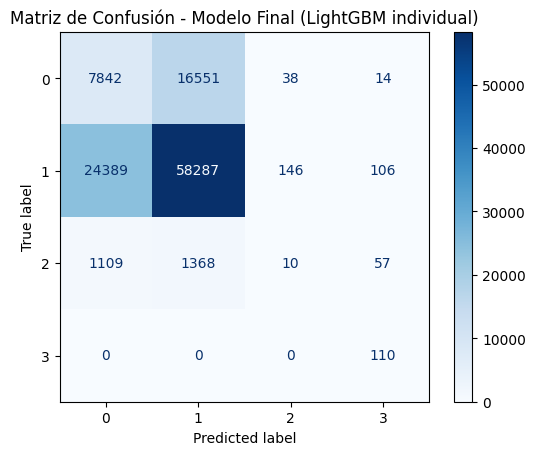

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = lgbm_best_params.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_best_params.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Modelo Final (LightGBM individual)")
plt.show()

Por medio de la matriz de confusión, podemos ver que nuestro `LightGBM individual` predice correctamente todas las instancias verdaderas positivas para la Clase 3. Con esto, notamos también que tendió a clasificar bastante mal a la Clase #2. Esto sugiere de nuevo que no existen patrones fuertes para detectar correctamente esta clase.

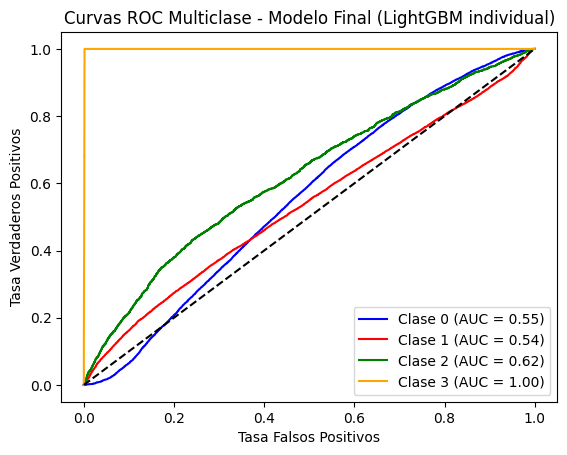

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
y_score = lgbm_best_params.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curvas ROC Multiclase - Modelo Final (LightGBM individual)")
plt.xlabel("Tasa Falsos Positivos")
plt.ylabel("Tasa Verdaderos Positivos")
plt.legend()
plt.show()

Las curvas ROC confirman que nuestro modelo cuenta con un problema de `overfitting` para las Clases `0`, `1` y `2` en nuestro entrenamiento, pero identifica correctamente todos los casos `severos (3)`. Esto indica que nuestros features deben de mejorar o la gobernanza de la data debe ser más estricta para asegurar un poder predictivo mayor.

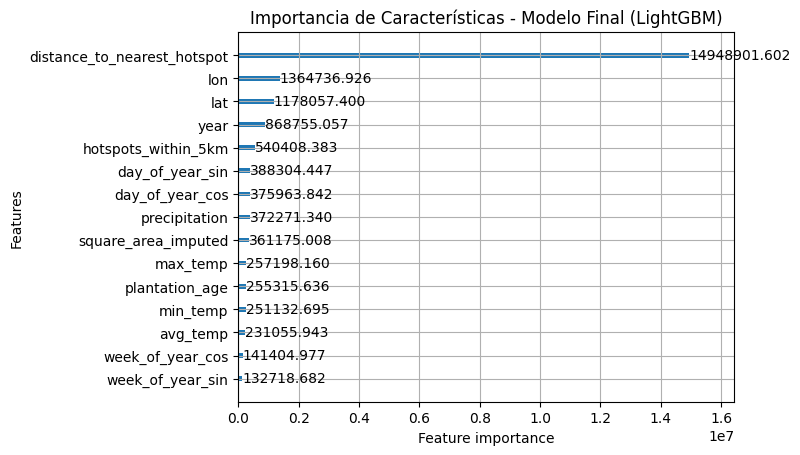

In [8]:
import lightgbm as lgb
import pandas as pd

lgb.plot_importance(lgbm_best_params, max_num_features=15, importance_type='gain')
plt.title("Importancia de Características - Modelo Final (LightGBM)")
plt.show()

Notamos también que el feature `distance_to_nearest_hotspot` tuvo una importancia mucho mayor sobre las demás features. Esto indica que la distancia hacia focos severos es un predictor bastante fuerte. En 2do. y 3er. lugar encontramos a la `latitud` y `longitud`, que son variables espaciales también. Esto sugiere que nuestro modelo tiene una base geo-espacial para predecir las severidades.

En resumen, nuestro modelo depende abrumadoramente de información espacial, y por lo tanto, es necesario introducir o buscar más diversidad en  nuestros features para mejorar la generalización en todas las clases.

Por último, valdría la pena hacer la prueba de generar los valores de la columna `distance_to_nearest_hotspot` por medio de `rolling o lagging features`. Esto lo mencionamos ya que para generar la información de esta columna, hicimos uso de los hotspots detectados en los 15 días previos y posteriores al muestreo de la trampa; por lo tanto, existe la probabilidad de que al cambiar esta ventana temporal o generar rolling y lagging features podamos balancear la importancia de cada feature en la predicción.

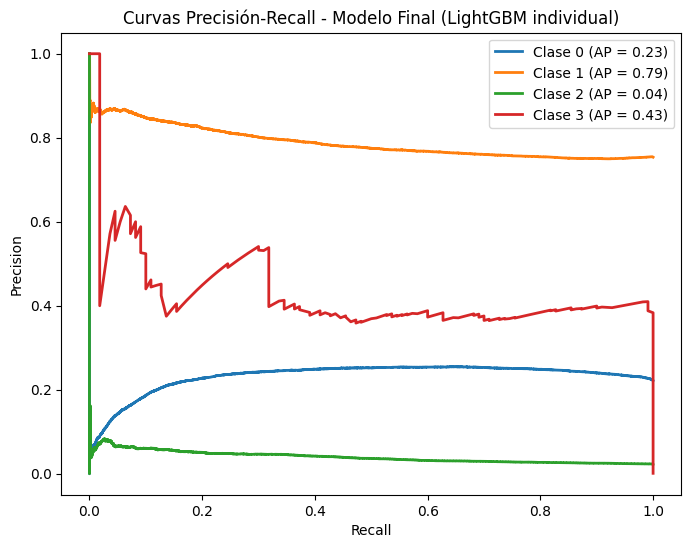

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
for i in range(4):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Clase {i} (AP = {average_precision_score(y_test_bin[:, i], y_score[:, i]):.2f})')
plt.title("Curvas Precisión-Recall - Modelo Final (LightGBM individual)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

La curva `Precisión–Recall` nos ayuda a evaluar la capacidad del modelo para identificar correctamente los casos positivos (recall) sin producir demasiados falsos positivos (precision). Esta métrica es más sensible al desbalance de clases, por lo que es más adecuada en contextos donde algunas categorías tienen pocas observaciones. Como hemos informado anteriormente, las Clases 0 y 2 son las que nuestro modelo predice con más errores, y por lo tanto podemos confirmar que nuestro modelo tiene  una capacidad bastante limitada para identificar patrones coherentes que le permitan predecir estas 2 clases correctamente.

En cuanto a la Clase 3, el modelo muestra un desempeño intermedio. El resultado es relevante desde la perspectiva de detectar focos de infestación severos, ya que que el modelo sí logra identificar una fracción significativa de éstos casos. No obstante, aún tenemos un margen de mejora para elevar su capacidad de detección.


En resumen, la curva Precision-Recall confirma que el modelo funciona moderadamente bien en la clase `(3)`, ya que detecta todos los verdaderos positivos, pero casi el 60% de sus predicciones son incorrectas (precision bajo, recall alto). También requiere ajustes para mejorar la precisión en el resto de categorías, ya que estas curvas sugieren que debemos hacer que nuestro modelo sea más sensible a las clases `0` y `2`.

# Ahora sí: Bayesian Optimization

Ahora que sabemos que nuestro LightGBM individual es el modelo que mejor generaliza nuestro dataset, haremos uso de éste como la función a optimizar de Bayesian Optimization para generar ubicaciones en las cuáles podrían existir infestaciones severas de gorgojos del agave. La idea general es que usaremos la probabilidad predecida por `LigthGBM individual` para la `Clase 3 (infestación severa)`, y aquellos puntos que se exploren por medio  de Bayesian Optimization que generen las mayores probabilidades serán seleccionados como posibles puntos de infestación severa.

Algo importante a tomar en cuenta es que aunque `LightGBM` tuvo un recall bastante alto  (`0.99`) y capturó casi el 100% de verdaderos positivos respecto a la severidad más alta, tiene un precision de aproximadamente `0.40`. Esto quiere decir que de 100 casos que LightGBM detecte como severos, solamente el 40% de los mismos realmente lo serán. Esto hace que nuestro modelo genere muchas falsas alertas, pero es algo que decidimos mantener ya que consideramos que clasificar erróneamente un verdadero positivo es más costoso.

Con esto, para llevar a cabo el barrido en el espacio de nuestros features, debemos restringir algunos features debido a que estamos tratando con predicciones temporales:

- Usaremos BO para los meses de Agosto a Diciembre  del año 2025.
- `Critical_Season` debe estar presente solo entre Mayo a Septiembre en el espacio de exploración.
- Usaremos el percentil 5 al 95 para evitar outliers en cada feature.
- Debemos tomar en cuenta que la temperatura promedio no puede ser mayor a la temperatura maxima, y tampoco menor que la temperatura mínima.
- BO explorará los features cíclicos por medio de la generación de ángulos que luego se convertirán a senos y cosenos. 

In [10]:
# Definimos columnas continuas y ciclicas
cols_cont = [
    "lat","lon","plantation_age","square_area_imputed","year",
    "critical_season","distance_to_nearest_hotspot","hotspots_within_5km",
    "precipitation","avg_temp","max_temp","min_temp"
]
cols_cyclic = [
    "day_of_year_sin","day_of_year_cos",
    "day_of_week_sin","day_of_week_cos",
    "week_of_year_sin","week_of_year_cos",
    "month_sin","month_cos"
]

# Usaremos los percentiles para evitar outliers
Q_LO, Q_HI = 0.05, 0.95

def qrange(s):
    return float(s.quantile(Q_LO)), float(s.quantile(Q_HI))


# Límites base por percentiles
lat_lo, lat_hi   = qrange(df["lat"])
lon_lo, lon_hi   = qrange(df["lon"])

age_lo, age_hi   = int(df["plantation_age"].min()), int(df["plantation_age"].max())
area_lo, area_hi = qrange(df["square_area_imputed"])
year_lo, year_hi = int(df["year"].min()), int(df["year"].max())

# Límites binarios
crit_lo, crit_hi = 0, 1

# Límites para variables continuas
dist_lo, dist_hi = max(0.0, df["distance_to_nearest_hotspot"].quantile(Q_LO)), float(df["distance_to_nearest_hotspot"].quantile(Q_HI))
hot5_lo, hot5_hi = int(df["hotspots_within_5km"].min()), int(df["hotspots_within_5km"].max())
prec_lo, prec_hi = max(0.0, df["precipitation"].quantile(Q_LO)), float(df["precipitation"].quantile(Q_HI))

# limites en temperaturas
tmin_lo, tmin_hi = qrange(df["min_temp"])
tmax_lo, tmax_hi = qrange(df["max_temp"])

# Generamos un diccionario con estos limites
bounds_base = {
    "lat": (lat_lo, lat_hi),
    "lon": (lon_lo, lon_hi),
    "plantation_age": (age_lo, age_hi),
    "square_area_imputed": (area_lo, area_hi),
    "year": (year_lo, year_hi),
    "critical_season": (crit_lo, crit_hi),
    "distance_to_nearest_hotspot": (dist_lo, dist_hi),
    "hotspots_within_5km": (hot5_lo, hot5_hi),
    "precipitation": (prec_lo, prec_hi),
    "min_temp": (tmin_lo, tmin_hi),
    "max_temp": (max(tmax_lo, tmin_lo), tmax_hi),  # aseguramos que el mínimo de max_temp no sea menor a tmin_lo
}

# Definimos un margen de exploracion en porcentaje
MARGIN = 0.05

def pad(lo, hi, m=MARGIN):
    span = hi - lo
    return lo - m*span, hi + m*span

# Aumentamos un 5% a los limites de algunas variables para darle mas libertad al modelo
for k in ["lat","lon","square_area_imputed","distance_to_nearest_hotspot","precipitation","min_temp","max_temp"]:
    lo, hi = bounds_base[k]
    bounds_base[k] = pad(lo, hi, MARGIN)


In [11]:
from bayes_opt import BayesianOptimization
import numpy as np

# Definimos algunas restricciones temporales
YEAR_FIXED = 2025
months = np.arange(8, 13)  # Agosto a Diciembre (12)

# Generamos un valor inicial para nuestros features cíclicos
month_sin_vals = np.sin(2 * np.pi * months / 12)
month_cos_vals = np.cos(2 * np.pi * months / 12)

month_encoding = list(zip(months, month_sin_vals, month_cos_vals))

# Esta funcion ayudará a obtener los features que maximizan la probabilidad de que nuestro LightGBM
# clasifique a una ubicacion como de alto riesgo
def point_to_features(p):

    # Elegimos un mes aleatorio dentro del rango fijo (8–12)
    month = np.random.choice(np.arange(8, 13))
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    # Definimos la temporada crítica con base en el mes que se explore
    critical_season = 1 if 5 <= month <= 9 else 0

    # Variables angulares que luego se vuelven cíclicas al aplicar
    # seno y coseno
    doy_sin = np.sin(p["theta_doy"]);  doy_cos = np.cos(p["theta_doy"])
    dow_sin = np.sin(p["theta_dow"]);  dow_cos = np.cos(p["theta_dow"])
    woy_sin = np.sin(p["theta_woy"]);  woy_cos = np.cos(p["theta_woy"])

    # Discretizamos estos valores para evitar valores como 2.5, 3.7, etc.
    plantation_age = int(round(p["plantation_age"]))
    hotspots_5km = int(round(np.clip(p["hotspots_within_5km"], 
                                     bounds_base["hotspots_within_5km"][0], 
                                     bounds_base["hotspots_within_5km"][1])))

    # Debemos asegurar que las temperaturas a tomar en cuenta sean coherentes
    min_t = float(np.clip(p["min_temp"], *bounds_base["min_temp"]))
    delta_max = max(0.0, p["delta_max"])
    max_t = min(min_t + delta_max, bounds_base["max_temp"][1])
    max_t = max(max_t, bounds_base["max_temp"][0])
    f_avg = 1.0 / (1.0 + np.exp(-p["avg_frac_logit"]))
    avg_t = min_t + f_avg * (max_t - min_t)

    # Clampeos continuos
    lat = float(np.clip(p["lat"], *bounds_base["lat"]))
    lon = float(np.clip(p["lon"], *bounds_base["lon"]))
    area = float(np.clip(p["square_area_imputed"], *bounds_base["square_area_imputed"]))
    dist = float(np.clip(p["distance_to_nearest_hotspot"], *bounds_base["distance_to_nearest_hotspot"]))
    prec = float(np.clip(p["precipitation"], *bounds_base["precipitation"]))

    # Construimos un vector columna final
    x = {
        "lat": lat,
        "lon": lon,
        "plantation_age": plantation_age,
        "square_area_imputed": area,
        "year": YEAR_FIXED,
        "day_of_year_sin": doy_sin,
        "day_of_year_cos": doy_cos,
        "day_of_week_sin": dow_sin,
        "day_of_week_cos": dow_cos,
        "week_of_year_sin": woy_sin,
        "week_of_year_cos": woy_cos,
        "month_sin": month_sin,
        "month_cos": month_cos,
        "critical_season": critical_season,
        "distance_to_nearest_hotspot": dist,
        "hotspots_within_5km": hotspots_5km,
        "precipitation": prec,
        "avg_temp": avg_t,
        "max_temp": max_t,
        "min_temp": min_t,
        "month_num": month  # Esto nos servirá para verificar que solo tengamos meses del 8 al 12 de 2025
    }
    return x

In [12]:
# Esta funcion busca maximizar dónde podrían existir infestaciones severas (Clase 3) por medio
# de la predicción que nuestro LightGBM calcule
def make_objective(trained_model, feature_order):
    def objective(**p):
        x = point_to_features(p)
        X_df = pd.DataFrame([x])[feature_order]
        proba = trained_model.predict_proba(X_df)[0, 3]
        return float(proba)
    return objective

In [13]:
# Ahora definimos el espacio de busqueda para BO
pbounds = {
    "lat": bounds_base["lat"],
    "lon": bounds_base["lon"],
    "plantation_age": (bounds_base["plantation_age"][0], bounds_base["plantation_age"][1]),
    "square_area_imputed": bounds_base["square_area_imputed"],
    "distance_to_nearest_hotspot": bounds_base["distance_to_nearest_hotspot"],
    "hotspots_within_5km": (bounds_base["hotspots_within_5km"][0], bounds_base["hotspots_within_5km"][1]),
    "precipitation": bounds_base["precipitation"],
    "min_temp": bounds_base["min_temp"],
    "delta_max": (0.0, max(0.1, bounds_base["max_temp"][1] - bounds_base["min_temp"][0])),
    "avg_frac_logit": (-4.0, 4.0),
    "theta_doy": (0.0, 2*np.pi),
    "theta_dow": (0.0, 2*np.pi),
    "theta_woy": (0.0, 2*np.pi),
}

# Orden de las columnas a pasar a nuestro modelo
feature_order = [
    "lat","lon","plantation_age","square_area_imputed","year",
    "day_of_year_sin","day_of_year_cos","day_of_week_sin","day_of_week_cos",
    "week_of_year_sin","week_of_year_cos","month_sin","month_cos",
    "critical_season","distance_to_nearest_hotspot","hotspots_within_5km",
    "precipitation","avg_temp","max_temp","min_temp"
]

optimizer = BayesianOptimization(
    f=make_objective(lgbm_best_params, feature_order),
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=20, n_iter=120)

|   iter    |  target   |    lat    |    lon    | planta... | square... | distan... | hotspo... | precip... | min_temp  | delta_max | avg_fr... | theta_doy | theta_dow | theta_woy |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.0002080 | 20.428493 | -100.4791 | 13.907884 | 24.038107 | 1218.7237 | 5.4598082 | 3.1882078 | 22.569728 | 18.610520 | 1.6645806 | 0.1293361 | 6.0941233 | 5.2303913 |
| 2         | 0.0003787 | 20.102498 | -104.0700 | 3.4846856 | 11.420605 | 5273.2146 | 15.118075 | 62.045796 | 17.590079 | 4.3187299 | -1.662842 | 2.3019193 | 2.8655722 | 4.9334060 |
| 3         | -.088e-05 | 20.077043 | -102.5176 | 11.255876 | 0.3726788 | 6183.5224 | 5.9683443 | 4.9472746 | 24.189178 | 29.895967 | 2.4671787 | 1.9139447 | 0.6136919 | 4.2991628 |
| 4         | 0.0001173 | 20.560362 | -104.3492 | 9.4083612 | -0.144245 | 9501.7237 | 9.05

In [14]:
# Candidatos a visitar por posible infestación severa de gorgojos
def get_top_candidates(optimizer, top_n=50):
    rows = []
    for res in optimizer.res:
        p = res["params"].copy()
        x = point_to_features(p)
        x["Class3_Prob"] = res["target"]
        rows.append(x)
    df_cand = pd.DataFrame(rows).sort_values("Class3_Prob", ascending=False)
    return df_cand.head(top_n)


# Generamos los candidatos que obtuvieron la probabilidad más alta de ser casos severos
# según LightGBM
top_candidates = get_top_candidates(optimizer, top_n=100)

Por último, luego de usar Bayesian Optimization para explorar el espacio definido por nuestros features, más un 5% de variabilidad, podemos obtener las coordenadas que tuvieron la probabilidad más alta de ser catalogadas como severas por nuestro modelo seleccionado (Clase objetivo `3`). Debemos destacar que estas ubicaciones deberían visitarse según el mes y año de nuestra predicción.

Con esto, debemos tomar en cuenta que según nuestras métricas, el 40% de éstas ubicaciones podría ser un caso severo real.

In [20]:
top_candidates[['lat','lon', 'Class3_Prob']].head(10)

,lat,lon,Class3_Prob
103,19.675735,-100.248979,0.985139
112,19.675735,-100.248979,0.984817
106,19.972876,-102.009008,0.984397
64,19.675735,-100.248979,0.984089
137,19.920987,-100.473263,0.983430
102,21.389101,-102.673861,0.982092
128,19.675735,-100.248979,0.981071
126,19.675735,-100.248979,0.980834
33,21.685555,-100.248979,0.980553
98,19.675735,-100.248979,0.980109


In [16]:
top_candidates[['lat', 'lon']].to_csv('TopCandidates_coords.csv', index=False)

# Conclusiones

- El modelo final se eligió priorizando la métrica más representativa del problema, la cual definimos como la `F1-macro`. Esto permite tener un modelo enfocado en el balance entre precisión y recall para todas las clases. Este enfoque permitió optimizar el desempeño del modelo no solo en clases mayoritarias, sino también en las minoritarias, garantizando una predicción más justa para los diferentes niveles de severidad presentes en el conjunto de datos.

- Las gráficas generadas proporcionaron evidencia clara de la capacidad del modelo para distinguir entre las clases. Estos análisis confirmaron que el modelo final logró un nivel medio de discriminación entre los niveles de severidad. Algo importante es que se logró  una alta sensibilidad hacia los casos verdaderos positivos de la severidad más alta, que representan mayor relevancia para el negocio ya que definen el inicio del protocolo de erradicación del gorgojo en una finca o predio.

- El uso de Bayesian Optimization para hacer un barrido sobre el espacio de nuestros features permite que, con base en nuestro modelo final seleccionado, se puedan generar posibles ubicaciones en dónde puedan existir focos de infestación severos. Con esto, es importante notar que aunque nuestro modelo base (LightGBM) tiene un recall alto, al tener un precision bajo es posible generar más falsas que verdaderas alarmas.
  - Esto, según nuestro Sponsor, no es un problema ya que actualmente hacen el muestreo de forma aleatoria o cuando reciben algún reporte de infestación de los socios que forman parte de la CNIT.

# Referencias

- Agnihotri, A., & Batra, N. (2020). Exploring Bayesian optimization. Distill, 5(5), e26. https://doi.org/10.23915/distill.00026
- Breiman, L. (1996). Bagging predictors. Machine Learning, 24(2), 123–140.
- Freund, Y., & Schapire, R. E. (1997). A decision-theoretic generalization of on-line learning and an application to boosting. Journal of Computer and System Sciences, 55(1), 119–139.
- Kuncheva, L. I. (2004). Combining pattern classifiers: Methods and algorithms. Wiley-Interscience.
- Rokach, L. (2010). Ensemble-based classifiers. Artificial Intelligence Review, 33(1), 1–39.
- Wolpert, D. H. (1992). Stacked generalization. Neural Networks, 5(2), 241–259.